--------------
# Playbook 1 : Process the Malaria cell images data set
--------------
This playbooks takes the malaria cell image data set (assumes you have a copy on gdrive), and generates a processed version (re-scaling all images to 44x44 pixels). Both grayscale and colour image processed data sets are created. 

You can obtain a copy of the cell images dataet from 
* Kaggle - https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria/data#
* From the National Library of Medicice - https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip


## 1. Bring zipped copy of original data set across from gdrive to extract locally within colab

Define the root directory on google drive. This is the directory the repo is 
checked out to.

In [0]:
%env GPATH=/content/gdrive/My Drive/MSc AI/Project/msccode

from google.colab import drive
drive.mount('/content/gdrive')

env: GPATH=/content/gdrive/My Drive/MSc AI/Project/msccode
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### 1.1 Execute this if you want to take the raw data and process

In [0]:
!cp -f "$GPATH/Datasets/cell-images-for-detecting-malaria.zip" "cell-images.zip"
!rm -rf cell_images
!rm -rf dataset
!unzip -q "cell-images.zip"
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
cell_images  cell-images.zip  gdrive  sample_data
cell_images  cell-images.zip  gdrive  sample_data


### 1.2 Execute this if you just want to copy over an already preprocessed version of the data

In [0]:
!cp -f  "$GPATH/Datasets/processed-cell-images-malaria.zip" './processed-cell-images-malaria.zip'
!unzip -q './processed-cell-images-malaria.zip'
!ls 

dataset  gdrive  processed-cell-images-malaria.zip  sample_data


### 2. Import required packages

In [0]:
import os
import shutil
import numpy as np
import cv2

## 3. Define constants

In [0]:
IMG_SIZE = 44         # Data set images will be reframed to this width and height
TEST_FRACTION = 0.1   # Fraction of dataset to hold out for test purposes
VAL_SPLIT = 0.1       # Ammount of training data to use for validation
TEST_SPLIT = 0.1

data_dir = './cell_images'

# Source dataset image directories
srcP = "./cell_images/Parasitized"
srcU = "./cell_images/Uninfected"

# Target image directory for 'processed' color images.
colorData = "./dataset/color/"
dstColorP = "./dataset/color/Parasitized/"
dstColorU = "./dataset/color/Uninfected/"

# Target image directory for 'processed' grayscale images.
grayData = "./dataset/gray/"
dstGrayP = "./dataset/gray/Parasitized/"
dstGrayU = "./dataset/gray/Uninfected/"

dataset_p_dirs=[dstColorP, dstGrayP]
dataset_u_dirs=[dstColorU, dstGrayU]

## 4. Split Image data set into train and test set directories. 
We create 2 data sets. One for color images and a second for grayscale. 

In [0]:
def partition_files(srcP, 
                    srcU, 
                    dataset_p_dirs, 
                    dataset_u_dirs):
    print("Number of files in {} is {} ".format(srcP, len(os.listdir(srcP)))) 
    print("Number of files in {} is {} ".format(srcU, len(os.listdir(srcU)))) 
    print()

    dataset_dirs = dataset_p_dirs + dataset_u_dirs

    for file_path in dataset_dirs:
        directory = os.path.dirname(file_path)
        try:
            os.stat(directory)
        except:
            print("Creating directory", file_path)
            os.makedirs(directory)

    print()

    filesP = [fn for fn in os.listdir(srcP) if fn.endswith(('.png'))]    
    filesU = [fn for fn in os.listdir(srcU) if fn.endswith(('.png'))]  

    # Copy to dataset p dir
    for index in range(len(filesP)):
        img_file = filesP[index]

        for dest in dataset_p_dirs:
            shutil.copy(srcP + '/'+ img_file, dest + '/'+ img_file)

    # Copy to dataset u dir
    for index in range(len(filesU)):
        img_file = filesU[index]

        for dest in dataset_u_dirs:
            shutil.copy(srcU + '/'+ img_file, dest + '/'+ img_file)

partition_files(srcP,
                srcU,
                dataset_p_dirs, 
                dataset_u_dirs)

for d in dataset_p_dirs + dataset_u_dirs:
    print("Number of files in {} is {} ".format(d, len(os.listdir(d))))

Number of files in ./cell_images/Parasitized is 13780 
Number of files in ./cell_images/Uninfected is 13780 

Creating directory ./dataset/color/Parasitized/
Creating directory ./dataset/gray/Parasitized/
Creating directory ./dataset/color/Uninfected/
Creating directory ./dataset/gray/Uninfected/

Number of files in ./dataset/color/Parasitized/ is 13779 
Number of files in ./dataset/gray/Parasitized/ is 13779 
Number of files in ./dataset/color/Uninfected/ is 13779 
Number of files in ./dataset/gray/Uninfected/ is 13779 


##5. Process images. 
### 5.1 Standardise images
- We normalise all images to a standard size (IMG_SIZE * IMG_SIZE). 
-Gray scale images are generated by reducing 3 channel RGB to single channel greyscale. 

In [0]:
def preprocess_color_images(dataset_dirs):
    for directory in dataset_dirs:
        files = [fn for fn in os.listdir(directory) if fn.endswith(('.png'))] 
        print("Processing images in {}".format(directory))
        num_rescaled = 0
        for img_file in files:
            file_path = directory + '/' + img_file
            img = cv2.imread(file_path)
            height, width, channels = img.shape
            if height != width or height != IMG_SIZE:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_AREA) 
                cv2.imwrite(file_path, img)
                num_rescaled += 1
        print("Re-scaled {} images in {}".format(num_rescaled, directory))

dataset_dirs=[dstColorP, dstColorU]
preprocess_color_images(dataset_dirs)

Processing images in ./dataset/color/Parasitized/
Re-scaled 13779 images in ./dataset/color/Parasitized/
Processing images in ./dataset/color/Uninfected/
Re-scaled 13779 images in ./dataset/color/Uninfected/


In [0]:
from skimage import io
from skimage import color
from skimage.transform import resize
from skimage import img_as_ubyte

def preprocess_gray_images(dataset_dirs):
    for directory in dataset_dirs:
        files = [fn for fn in os.listdir(directory) if fn.endswith(('.png'))] 
        print("Processing images in {}".format(directory))
        num_rescaled = 0
        for img_file in files:
            file_path = directory + '/' + img_file
            img = color.rgb2gray(io.imread(file_path))
            img = img * 255
            img = img.astype(np.uint8)          
            height, width = img.shape
            if height != width or height != IMG_SIZE:
                img = resize(img, (IMG_SIZE, IMG_SIZE)) 
                io.imsave(file_path, img_as_ubyte(img))
                num_rescaled += 1
        print("Re-scaled and gray-scaled {} images in {}".format(num_rescaled, directory))

dataset_dirs=[dstGrayP, dstGrayU]
preprocess_gray_images(dataset_dirs)

Processing images in ./dataset/gray/Parasitized/
Re-scaled and gray-scaled 13779 images in ./dataset/gray/Parasitized/
Processing images in ./dataset/gray/Uninfected/
Re-scaled and gray-scaled 13779 images in ./dataset/gray/Uninfected/


### 5.2 Copy processed images to google drive

In [0]:
%rm -rf ./cell_images
!zip -q -r processed-cell-images-malaria.zip ./dataset
!cp -f './processed-cell-images-malaria.zip' "$GPATH/Datasets/processed-cell-images-malaria.zip" 

##6. Define function to load dataset into numpy arrays

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

def loadData(directory, labelMap, as_gray): 
    array_list = [] 
    label_list = []

    labels = [dn for dn in os.listdir(directory) if os.path.isdir(directory + '/' + dn)]

    for label in labels:
        classLabel = labelMap[label]
        subdir = directory + '/' + label
        files = [fn for fn in os.listdir(subdir) if fn.endswith(('.png'))] 
        print("Loading images for class {} from {}".format(classLabel, subdir))
        num_loaded = 0
        for img_file in files:
            file_path = subdir + '/' + img_file
            if as_gray is True:
                img = cv2.imread(file_path, 0)
            else:
                img = cv2.imread(file_path)
            img = img.astype('float32')
            array_list.append(img)
            label_list.append(classLabel)
            num_loaded += 1
            if num_loaded % 1000 == 0:
                print("Loaded %d (of %d)..." %(num_loaded, len(files)))
        print("Completed loading %d (of %d) images" %(num_loaded, len(files)))
        print("")
        
    data = np.array(array_list)
    data /= 255.0
    return data, np.array(label_list)

def load_and_split_data(labelMap={"Uninfected": 0, "Parasitized":1},
                        gray=True, 
                        val_split=VAL_SPLIT, 
                        test_split=TEST_SPLIT):
    print("load_and_split_data called with Val/Test split fraction {}/{}".format(val_split, 
                                                                                 test_split))

    if gray: 
        data_X, data_Y  = loadData(grayData, labelMap, as_gray=True)
    else:
        data_X, data_Y  = loadData(colorData, labelMap, as_gray=False)
    idx = np.random.permutation(len(data_X))
    data_X, data_Y = data_X[idx], data_Y[idx]

    val_X = None; val_Y=None
    test_X = None; test_Y=None
    train_X = data_X; train_y = data_Y

    if test_split > 0:
        train_X, test_X, train_Y, test_Y = train_test_split(data_X, 
                                                            data_Y, 
                                                            test_size=test_split, 
                                                            stratify=data_Y)
    if val_split > 0:
        train_X, val_X, train_Y, val_Y = train_test_split(train_X, 
                                                          train_Y, 
                                                          test_size=val_split, 
                                                          stratify=train_Y)
    if gray:
        train_X = train_X.reshape(-1, IMG_SIZE,IMG_SIZE, 1).astype('float32')
        if val_split > 0:
            val_X = val_X.reshape(-1,IMG_SIZE,IMG_SIZE, 1).astype('float32')
        if test_split > 0:
            test_X = test_X.reshape(-1,IMG_SIZE,IMG_SIZE, 1).astype('float32')
    else:
        train_X = train_X.reshape(-1, IMG_SIZE,IMG_SIZE, 3).astype('float32')
        if val_split > 0:
            val_X = val_X.reshape(-1,IMG_SIZE,IMG_SIZE, 3).astype('float32')
        if test_split > 0:
            test_X = test_X.reshape(-1,IMG_SIZE,IMG_SIZE, 3).astype('float32')  

    print("Training data set size is", train_X.shape, train_Y.shape)
    if val_split > 0:
        print("Validation data set size is",val_X.shape, val_Y.shape)
    if test_split > 0:
        print("Test data data set size is",test_X.shape, test_Y.shape)

    labels, counts = np.unique(train_Y, return_counts=True)
    print("Training data labels and counts are", labels, counts)
    if val_split > 0:
        labels, counts = np.unique(val_Y, return_counts=True)
        print("Validation data labels and counts are", labels, counts)
    if test_split > 0:
        labels, counts = np.unique(test_Y, return_counts=True)
        print("Test data labels and counts are", labels, counts)

    return (train_X, train_Y, val_X, val_Y, test_X, test_Y)

def k_fold_load_and_split(gray, splits=10, test_split=TEST_SPLIT):
    print("k_fold_load_and_split called for {} splits and test fraction {}".format(splits, 
                                                                                   test_split))

    data_X, data_Y, _, _, test_X, test_Y = load_and_split_data(gray=gray, 
                                                               val_split=0,
                                                               test_split = test_split)

    skf = StratifiedKFold(n_splits=splits,shuffle=False) 
    folds = skf.split(data_X, data_Y) 

    return (data_X, data_Y, folds, test_X, test_Y)

##7. Define function for image display

In [0]:
import matplotlib.pyplot as plt
import math 

def showImgs(data, labels, num_imgs, cols=4, file=None):
    classes = len(np.unique(labels))
    rows = math.ceil(num_imgs * classes / cols)

    fig = plt.figure(figsize=(1.8*cols, 1.5*rows))  
    img_num = 0
    index_num = 0
    for label in range(classes):
        for num in range(num_imgs):
            for index in range(index_num, len(labels)):         
                if label == labels[index]:
                    index_num = index + 1
                    pixels = data[index]
                    shape = pixels.shape
                    img_num += 1
                    f = fig.add_subplot(rows,cols,img_num)
                    f.set_title("Class %d"% label)
                    f.set_xticks([])
                    f.set_yticks([])
                    if len(shape) == 2 or shape[2] == 1:
                        plt.imshow(pixels[:,:,0], cmap='gray') 
                    else:
                        plt.imshow(pixels[:,:,::-1]) # BGR -> RGB
                    break

    plt.tight_layout()
    plt.show()
    
    if file is not None:
        fig.savefig(file)

##8. Test loading of gray scale and color images


###8.1 Test gray

In [0]:
(train_X, train_Y, val_X, val_Y, test_X, test_Y) = load_and_split_data()

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 0 from ./dataset/gray//Uninfected
Loaded 1000 (of 13779)...
Loaded 2000 (of 13779)...
Loaded 3000 (of 13779)...
Loaded 4000 (of 13779)...
Loaded 5000 (of 13779)...
Loaded 6000 (of 13779)...
Loaded 7000 (of 13779)...
Loaded 8000 (of 13779)...
Loaded 9000 (of 13779)...
Loaded 10000 (of 13779)...
Loaded 11000 (of 13779)...
Loaded 12000 (of 13779)...
Loaded 13000 (of 13779)...
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/gray//Parasitized
Loaded 1000 (of 13779)...
Loaded 2000 (of 13779)...
Loaded 3000 (of 13779)...
Loaded 4000 (of 13779)...
Loaded 5000 (of 13779)...
Loaded 6000 (of 13779)...
Loaded 7000 (of 13779)...
Loaded 8000 (of 13779)...
Loaded 9000 (of 13779)...
Loaded 10000 (of 13779)...
Loaded 11000 (of 13779)...
Loaded 12000 (of 13779)...
Loaded 13000 (of 13779)...
Completed loading 13779 (of 13779) images

Training data set size is (22321, 44, 44, 1) (2

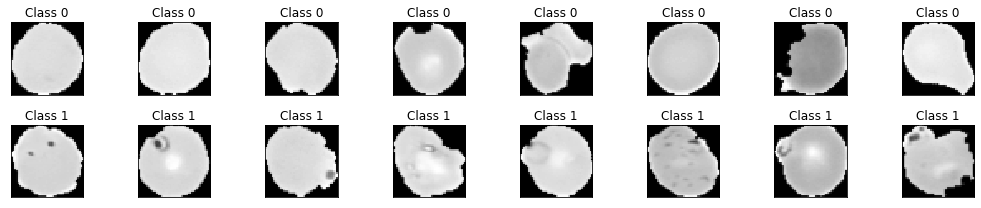

In [0]:
showImgs(test_X, test_Y, 8, cols=8, file='1_grey.png')

###8.2 Test Color

In [0]:
(train_X, train_Y, val_X, val_Y, test_X, test_Y) = load_and_split_data(gray=False)

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 1 from ./dataset/color//Parasitized
Loaded 1000 (of 13779)...
Loaded 2000 (of 13779)...
Loaded 3000 (of 13779)...
Loaded 4000 (of 13779)...
Loaded 5000 (of 13779)...
Loaded 6000 (of 13779)...
Loaded 7000 (of 13779)...
Loaded 8000 (of 13779)...
Loaded 9000 (of 13779)...
Loaded 10000 (of 13779)...
Loaded 11000 (of 13779)...
Loaded 12000 (of 13779)...
Loaded 13000 (of 13779)...
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/color//Uninfected
Loaded 1000 (of 13779)...
Loaded 2000 (of 13779)...
Loaded 3000 (of 13779)...
Loaded 4000 (of 13779)...
Loaded 5000 (of 13779)...
Loaded 6000 (of 13779)...
Loaded 7000 (of 13779)...
Loaded 8000 (of 13779)...
Loaded 9000 (of 13779)...
Loaded 10000 (of 13779)...
Loaded 11000 (of 13779)...
Loaded 12000 (of 13779)...
Loaded 13000 (of 13779)...
Completed loading 13779 (of 13779) images

Training data set size is (22321, 44, 44, 3) 

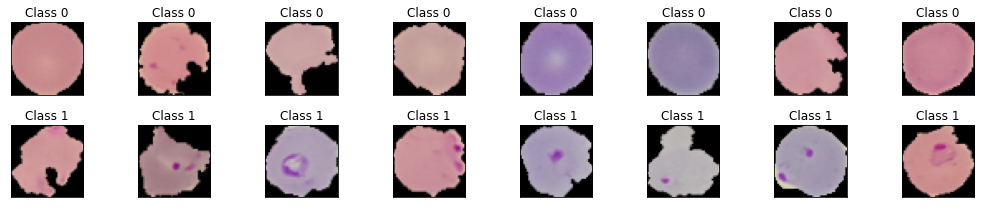

In [0]:
showImgs(train_X, train_Y, 8, cols=8, file='1_color.png')

###8.3 Test K-fold splitting of data

In [0]:
(train_X, train_Y, folds, test_X, test_Y) = k_fold_load_and_split(gray=False)

k_fold_load_and_split called for 10 splits and test fraction 0.1
load_and_split_data called with Val/Test split fraction 0/0.1
Loading images for class 1 from ./dataset/color//Parasitized
Loaded 1000 (of 13779)...
Loaded 2000 (of 13779)...
Loaded 3000 (of 13779)...
Loaded 4000 (of 13779)...
Loaded 5000 (of 13779)...
Loaded 6000 (of 13779)...
Loaded 7000 (of 13779)...
Loaded 8000 (of 13779)...
Loaded 9000 (of 13779)...
Loaded 10000 (of 13779)...
Loaded 11000 (of 13779)...
Loaded 12000 (of 13779)...
Loaded 13000 (of 13779)...
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/color//Uninfected
Loaded 1000 (of 13779)...
Loaded 2000 (of 13779)...
Loaded 3000 (of 13779)...
Loaded 4000 (of 13779)...
Loaded 5000 (of 13779)...
Loaded 6000 (of 13779)...
Loaded 7000 (of 13779)...
Loaded 8000 (of 13779)...
Loaded 9000 (of 13779)...
Loaded 10000 (of 13779)...
Loaded 11000 (of 13779)...
Loaded 12000 (of 13779)...
Loaded 13000 (of 13779)...
Completed loading 13779 (

In [0]:
for train_index, test_index in folds:
    fold_X = train_X[train_index] 
    fold_Y = train_Y[train_index]
    showImgs(fold_X, fold_Y, 8, cols=8)
    print(fold_X.shape, fold_Y.shape)


In [0]:
%%bash
cp -f ./*.png "$GPATH/Images"